In [90]:
import warnings
warnings.filterwarnings('ignore')

#General Data/Plotting
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
import random

# Language
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re 
from collections import Counter
from string import punctuation

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()

In [91]:
df = pd.read_json('../Datasets/Cell_Phones_and_Accessories_5.json', lines=True)

In [92]:
df['helpful_0'] = df['helpful'].apply(func=lambda x: x[0])
df['helpful_1'] = df['helpful'].apply(func=lambda x: x[1])


#### EDA v0

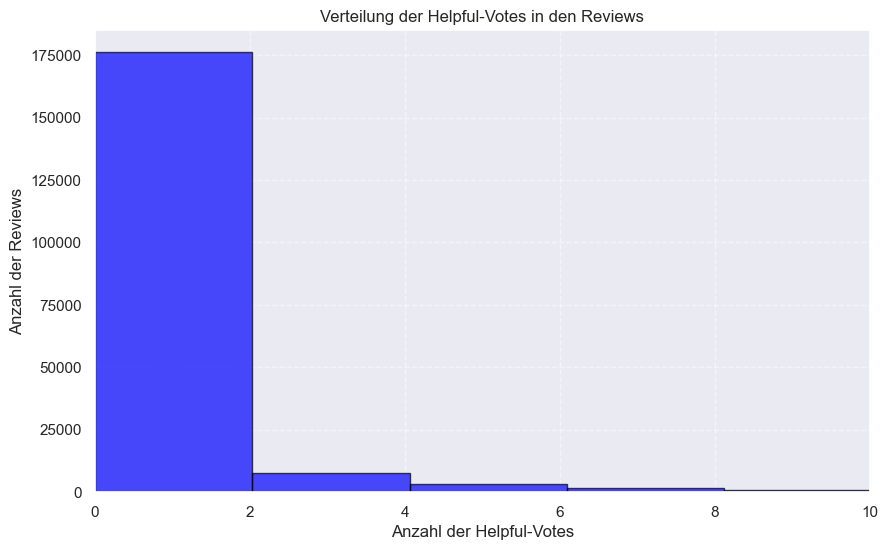

In [93]:
# Plot erstellen
plt.figure(figsize=(10, 6))
plt.hist(df['helpful_1'], bins=1000, color='blue', edgecolor='black', alpha=0.7)

# Titel und Beschriftungen hinzufügen
plt.title('Verteilung der Helpful-Votes in den Reviews')
plt.xlabel('Anzahl der Helpful-Votes')
plt.ylabel('Anzahl der Reviews')

# Gitter hinzufügen
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(0, 10)

# Diagramm anzeigen
plt.show()

In [94]:
# Remove Reviews that have less than 2 helpful votes
df = df[df['helpful_1'] >= 4]
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_0,helpful_1
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013",4,4
13,ANMATY0L0HX6Y,3998899561,Sasha Malkin,"[12, 16]","Unlike Most of the Rechargeable Battery cases,...",5,Best Rechargeable Battery Case on the Market!!...,1380240000,"09 27, 2013",12,16
27,A29OXVQRZ154KX,6073894996,Don Powell,"[3, 4]",This is a nice charger but you can tell it was...,4,Solid Charger but RF noisy,1363737600,"03 20, 2013",3,4
88,A1AGQVCNRY2G8G,8288853439,MDB,"[4, 4]",This Charger is awesome! First of all I wasn't...,5,Galaxy S4 Charger,1386720000,"12 11, 2013",4,4
167,A2JWEDW5FSVB0F,9658231950,Adam,"[1, 4]",couldnt watch movies on the htc without the ba...,5,Just what i needed,1398297600,"04 24, 2014",1,4


In [95]:
df['helpful_ratio'] = df['helpful_0'] / df['helpful_1']


In [96]:
df['ratio_percent'] = (df['helpful_ratio'] * 100).astype(int)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_0,helpful_1,helpful_ratio,ratio_percent
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013",4,4,1.00,100
13,ANMATY0L0HX6Y,3998899561,Sasha Malkin,"[12, 16]","Unlike Most of the Rechargeable Battery cases,...",5,Best Rechargeable Battery Case on the Market!!...,1380240000,"09 27, 2013",12,16,0.75,75
27,A29OXVQRZ154KX,6073894996,Don Powell,"[3, 4]",This is a nice charger but you can tell it was...,4,Solid Charger but RF noisy,1363737600,"03 20, 2013",3,4,0.75,75
88,A1AGQVCNRY2G8G,8288853439,MDB,"[4, 4]",This Charger is awesome! First of all I wasn't...,5,Galaxy S4 Charger,1386720000,"12 11, 2013",4,4,1.00,100
167,A2JWEDW5FSVB0F,9658231950,Adam,"[1, 4]",couldnt watch movies on the htc without the ba...,5,Just what i needed,1398297600,"04 24, 2014",1,4,0.25,25


In [97]:
df.drop(['reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'reviewTime'], axis='columns', inplace=True)

In [98]:
df.head()

,helpful,reviewText,overall,summary,helpful_0,helpful_1,helpful_ratio,ratio_percent
3,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,1.00,100
13,"[12, 16]","Unlike Most of the Rechargeable Battery cases,...",5,Best Rechargeable Battery Case on the Market!!...,12,16,0.75,75
27,"[3, 4]",This is a nice charger but you can tell it was...,4,Solid Charger but RF noisy,3,4,0.75,75
88,"[4, 4]",This Charger is awesome! First of all I wasn't...,5,Galaxy S4 Charger,4,4,1.00,100
167,"[1, 4]",couldnt watch movies on the htc without the ba...,5,Just what i needed,1,4,0.25,25


In [99]:
df = df.rename(columns={"reviewText":"Review","overall": "Rating"})

df['review_len'] = [len(text.split()) for text in df.Review]
df.head()

,helpful,Review,Rating,summary,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len
3,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,1.00,100,51
13,"[12, 16]","Unlike Most of the Rechargeable Battery cases,...",5,Best Rechargeable Battery Case on the Market!!...,12,16,0.75,75,239
27,"[3, 4]",This is a nice charger but you can tell it was...,4,Solid Charger but RF noisy,3,4,0.75,75,83
88,"[4, 4]",This Charger is awesome! First of all I wasn't...,5,Galaxy S4 Charger,4,4,1.00,100,171
167,"[1, 4]",couldnt watch movies on the htc without the ba...,5,Just what i needed,1,4,0.25,25,40


In [100]:
def convert_label(df) : 
    if df['ratio_percent'] <= 70 : 
        rate = 0 # for Negative 
    else : 
        rate = 1 # for Positive
        
    return rate

In [101]:
df['IsHelpful'] = df.apply(convert_label, axis = 1)
df.head()

,helpful,Review,Rating,summary,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful
3,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,1.00,100,51,1
13,"[12, 16]","Unlike Most of the Rechargeable Battery cases,...",5,Best Rechargeable Battery Case on the Market!!...,12,16,0.75,75,239,1
27,"[3, 4]",This is a nice charger but you can tell it was...,4,Solid Charger but RF noisy,3,4,0.75,75,83,1
88,"[4, 4]",This Charger is awesome! First of all I wasn't...,5,Galaxy S4 Charger,4,4,1.00,100,171,1
167,"[1, 4]",couldnt watch movies on the htc without the ba...,5,Just what i needed,1,4,0.25,25,40,0


In [102]:
# Drop reviews below 10 words
#df = df[~(df['review_len'] < 10)]

In [103]:
df.sort_values(by='ratio_percent', ascending=False, inplace=True)
df.head()

,helpful,Review,Rating,summary,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful
3,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,1.0,100,51,1
80577,"[4, 4]",This is the second stylus pen I have tried. Wh...,3,It does the job,4,4,1.0,100,169,1
82631,"[7, 7]","Broken in the corner, so my phone doesn't even...",2,Broken when I received it..,7,7,1.0,100,26,1
82589,"[6, 6]",This adapter works well when it connects but i...,3,Picky adapter!!,6,6,1.0,100,28,1
82586,"[5, 5]",Seems to do what its supposed to do. slightly ...,3,2 port USB car adapter,5,5,1.0,100,207,1


### Data Prepossessing :ghost:

In [104]:
def DataPrep(text) : 
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    
    # tokenization 
    tokens = nltk.word_tokenize(text) 
    
    # remove puncs 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if not word in stop_words]
    
    # lemmatization 
    words = [lemma.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    return text

In [105]:
df['cleaned_reviews'] = df['Review'].apply(DataPrep)

In [106]:
df.head()

,helpful,Review,Rating,summary,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful,cleaned_reviews
3,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,1.0,100,51,1,item arrived great time perfect condition howe...
80577,"[4, 4]",This is the second stylus pen I have tried. Wh...,3,It does the job,4,4,1.0,100,169,1,this second stylus pen i tried where first one...
82631,"[7, 7]","Broken in the corner, so my phone doesn't even...",2,Broken when I received it..,7,7,1.0,100,26,1,broken corner phone doesnt even stay case very...
82589,"[6, 6]",This adapter works well when it connects but i...,3,Picky adapter!!,6,6,1.0,100,28,1,this adapter work well connects pick chooses c...
82586,"[5, 5]",Seems to do what its supposed to do. slightly ...,3,2 port USB car adapter,5,5,1.0,100,207,1,seems supposed slightly heavy side not super t...


In [107]:
print(f'There are around {int(df["cleaned_reviews"].duplicated().sum())} duplicated reviews, we will remove them.')

There are around 69 duplicated reviews, we will remove them.


In [108]:
df.drop_duplicates("cleaned_reviews", inplace=True)

### EDA

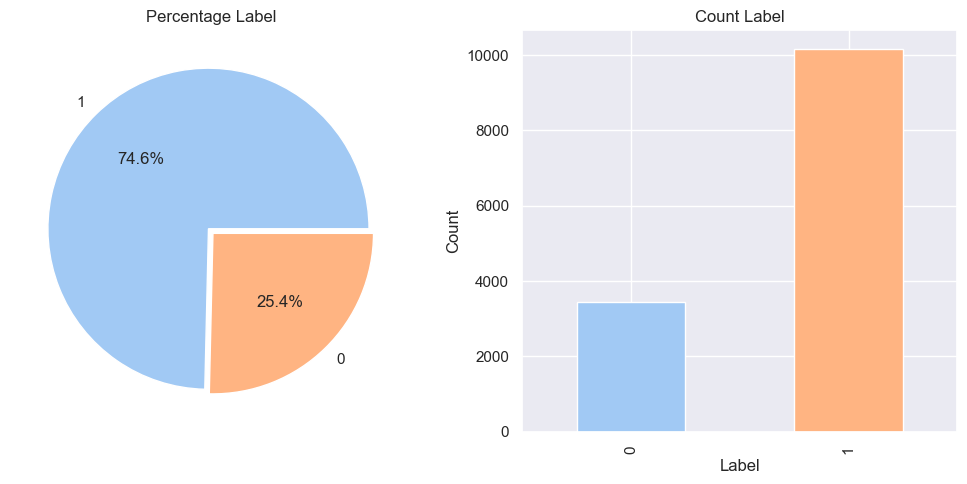

In [109]:
label_count = df['IsHelpful'].value_counts()
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

#sns.countplot(df['Rating'] , ax=axes[1])
counts = df['IsHelpful'].value_counts().sort_index()
counts.plot.bar(color=color)
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Split Data

In [110]:
x_train, x_val, y_train, y_val, len_train, len_val = train_test_split(df['cleaned_reviews'], df['IsHelpful'], df['review_len'], train_size=0.80, random_state=42)

In [111]:
len(x_train), len(x_val)

(10881, 2721)

### Feature Extraction

#### Was genau passiert hier?

In [112]:
vec = TfidfVectorizer()
vec.fit(x_train)
print("No. of feature words: ",len(vec.get_feature_names_out()))

No. of feature words:  58988


In [113]:
x_train = vec.transform(x_train).toarray()
x_val = vec.transform(x_val).toarray()

In [114]:
x_train.shape , x_val.shape

((10881, 58988), (2721, 58988))

In [115]:
# Add 'len' feature to the TF-IDF transformed data
x_train_combined = np.column_stack((x_train, len_train))
x_val_combined = np.column_stack((x_val, len_val))

In [116]:
print(x_train_combined)

[[   0.    0.    0. ...    0.    0.   27.]
 [   0.    0.    0. ...    0.    0.  173.]
 [   0.    0.    0. ...    0.    0.  983.]
 ...
 [   0.    0.    0. ...    0.    0. 1031.]
 [   0.    0.    0. ...    0.    0.  212.]
 [   0.    0.    0. ...    0.    0.  340.]]


In [117]:
x_train_combined.shape, x_val_combined.shape

((10881, 58989), (2721, 58989))

### Logistic Regression

### LR mit Review+IsHelpful

In [118]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train , y_train)

LogisticRegression(random_state=42)

In [119]:
train_acc1 = lr.score(x_train , y_train)

In [120]:
lr_pred = lr.predict(x_val)

val_acc1 = accuracy_score(y_val , lr_pred) 

val_precision1 = precision_score(y_val , lr_pred , average='weighted')
val_recall1 = recall_score(y_val , lr_pred , average='weighted')
val_f1score1 = f1_score(y_val , lr_pred , average='weighted')

In [121]:
print(f"The training accuracy for logistic regression : {(train_acc1*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1:0.2f}\n")

The training accuracy for logistic regression : 79.75%

The validation accuracy for logistic regression : 75.96%

The precision for logistic regression : 0.73

The recall for logistic regression : 0.76

The f1 score for logistic regression : 0.69



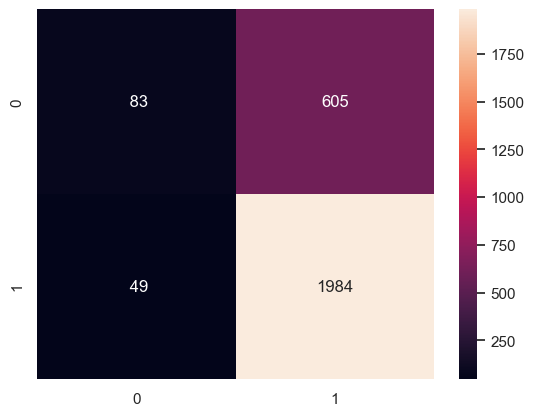

In [122]:
lr_cm = confusion_matrix(y_val , lr_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

In [143]:
def predict_helpfulness(review_text):
    # Vorverarbeitung des Texts (Tokenisierung, etc.)
    preprocessed_text = DataPrep(review_text)  # Du müsstest deine eigene Vorverarbeitungsfunktion implementieren

    # Umwandlung des vorverarbeiteten Texts in TF-IDF-Merkmale
    tfidf_features = vec.transform([preprocessed_text])

    # Vorhersage mit dem trainierten Logistic Regression-Modell
    prediction = lr.predict(tfidf_features)

    return prediction[0]

In [155]:
predict_helpfulness("Con: Christmas on the 24th of September. Pro: I love christmas!")

0

### LR mit Review+IsHelpful+Len

In [123]:
# Model mit review_len
lr1 = LogisticRegression(random_state=42)
lr1.fit(x_train_combined, y_train)

LogisticRegression(random_state=42)

In [124]:
train_acc1_2 = lr1.score(x_train_combined , y_train)

In [125]:
lr1_pred = lr1.predict(x_val_combined)

val_acc1_2 = accuracy_score(y_val , lr1_pred) 

val_precision1_2 = precision_score(y_val , lr1_pred , average='weighted')
val_recall1_2 = recall_score(y_val , lr1_pred , average='weighted')
val_f1score1_2 = f1_score(y_val , lr1_pred , average='weighted')

In [126]:
print(f"The training accuracy for logistic regression : {(train_acc1_2*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1_2*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1_2:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1_2:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1_2:0.2f}\n")

The training accuracy for logistic regression : 79.03%

The validation accuracy for logistic regression : 75.85%

The precision for logistic regression : 0.73

The recall for logistic regression : 0.76

The f1 score for logistic regression : 0.70



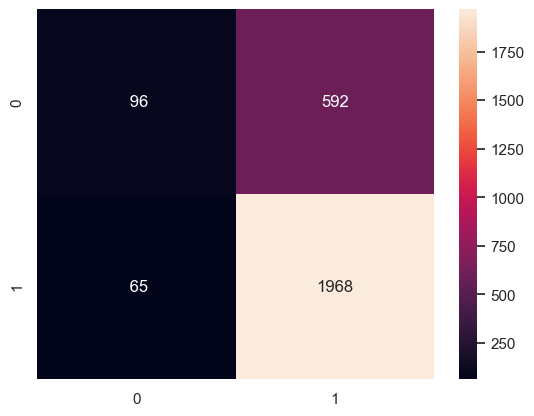

In [127]:
lr1_cm = confusion_matrix(y_val , lr1_pred)
sns.heatmap(lr1_cm, annot=True,fmt='3g')
plt.show()